# STAT 301 Group 40 Final Report

Wasay Hayat, Juhi Grover, Qi Xu, Xuanye Zheng(Allen)

Apri 16th, 2025

## Introduction

The growth of Airbnb has significantly changed how short-term rentals operate in major European cities. As more travelers choose Airbnb for its flexibility and affordability, it becomes increasingly important to understand what factors influence listing prices. For hosts, this insight can guide pricing strategies; for policymakers, it can help assess the platform’s impact on local housing markets.

In this project, we analyze a dataset of over 13,000 Airbnb listings across Paris, Barcelona, and Vienna. The dataset includes variables such as room type, number of guests, cleanliness rating, host status, and distance to city center. Our goal is to identify the most influential features affecting rental price and develop a model that can accurately predict it. This analysis can provide useful guidance for hosts, guests, and city planners alike.



**Overarching question:** How can various listing features as well as location and day type be used to predict the full price of accommodation of an Airbnb listing?

### Data Description

We are using data on Airbnb prices in European cities, downloaded from [Kaggle](https://www.kaggle.com/datasets/thedevastator/airbnb-prices-in-european-cities).

Original data source: Gyódi, K.and Ł. Nawaro. Determinants of Airbnb Prices in European Cities: A Spatial Econometrics Approach (supplementary Material). Zenodo, 13 Jan. 2021, [doi:10.5281/zenodo.4446043](doi:10.5281/zenodo.4446043).

Combining data from 3 cities (Paris, Barcelona, and Vienna), we have 13,058 observations and 22 columns, including 2 new columns created for this project.

| Variable Name            | Type | Description |
|--------------------------|-------------|-------------|
| `realSum`               |Numerical| The final rental price (response variable) |
| `room_type`             |Categorical| Type of room (private/shared/entire home/apt) |
| `room_shared`, `room_private`| Categorical (Binary)| Room is private or not |
| `multi` |Categorical (Binary)| indicator whether listing is for multiple rooms or not|
| `biz`|Categorical (Binary)| business indicator|
| `person_capacity`       |Numerical| Maximum number of guests allowed |
| `host_is_superhost`     |Categorical (Binary)| Whether the host is a "superhost" (TRUE/FALSE) |
| `cleanliness_rating`    |Numerical| Rating of cleanliness (1-10) |
| `guest_satisfaction_o`  |Numerical| Overall guest satisfaction score |
| `bedrooms`             |Numerical| Number of bedrooms available |
| `dist`, `metro_dist`   |Numerical| Distance from the city center/metro station |
| `attr_index`, `attr_index_norm`      |Numerical| Index and Normalized index of nearby attractions |
| `rest_index`, `rest_index_norm`      |Numerical| Index and Normalized index of nearby restaurants |
| `lng`, `lat`           |Numerical| Geolocation coordinates (longitude & latitude) |
| `city`           |Categorical| Paris or Barcelona or Vienna |
| `day_type`           |Categorical| weekdays or weekends|

## Methods and Results

### Exploratory Data Analysis

In [16]:
library(tidyverse)
library(repr)
library(tidymodels)
library(glmnet)
library(patchwork)

library(caret)
library(dplyr)

In [5]:
# Main developer: Wasay

barcelona_weekdays <- read_csv("https://raw.githubusercontent.com/awhayat/stat-301-project/refs/heads/main/barcelona_weekdays.csv") |>
    mutate(city = "Barcelona", day_type = "weekday")
barcelona_weekends <- read_csv("https://raw.githubusercontent.com/awhayat/stat-301-project/refs/heads/main/barcelona_weekends.csv") |>
    mutate(city = "Barcelona", day_type = "weekend")
paris_weekdays <- read_csv("https://raw.githubusercontent.com/awhayat/stat-301-project/refs/heads/main/paris_weekdays.csv") |>
    mutate(city = "Paris", day_type = "weekday")
paris_weekends <- read_csv("https://raw.githubusercontent.com/awhayat/stat-301-project/refs/heads/main/paris_weekends.csv") |>
    mutate(city = "Paris", day_type = "weekend")
vienna_weekdays <- read_csv("https://raw.githubusercontent.com/awhayat/stat-301-project/refs/heads/main/vienna_weekdays.csv") |>
    mutate(city = "Vienna", day_type = "weekday")
vienna_weekends <- read_csv("https://raw.githubusercontent.com/awhayat/stat-301-project/refs/heads/main/vienna_weekends.csv") |>
    mutate(city = "Vienna", day_type = "weekend")

airbnb_data <- bind_rows(paris_weekdays, paris_weekends, barcelona_weekdays, barcelona_weekends, vienna_weekdays, vienna_weekends)
head(airbnb_data)

New names:
• `` -> `...1`
Rows: 1555 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): room_type
dbl (16): ...1, realSum, person_capacity, multi, biz, cleanliness_rating, gu...
lgl  (3): room_shared, room_private, host_is_superhost

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 1278 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): room_type
dbl (16): ...1, realSum, person_capacity, multi, biz, cleanliness_rating, gu...
lgl  (3): room_shared, room_private, host_is_superhost

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 3130 Columns: 20
── Column specification ─────────────────

...1,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,⋯,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,day_type
<dbl>,<dbl>,<chr>,<lgl>,<lgl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0,296.1599,Private room,FALSE,TRUE,2,TRUE,0,0,10,⋯,0.6998206,0.1937094,518.4789,25.23938,1218.6622,71.60803,2.35385,48.86282,Paris,weekday
1,288.2375,Private room,FALSE,TRUE,2,TRUE,0,0,10,⋯,2.1000054,0.1072207,873.2170,42.50791,1000.5433,58.79146,2.32436,48.85902,Paris,weekday
2,211.3431,Private room,FALSE,TRUE,2,FALSE,0,0,10,⋯,3.3023251,0.2347238,444.5561,21.64084,902.8545,53.05131,2.31714,48.87475,Paris,weekday
3,298.9561,Entire home/apt,FALSE,FALSE,2,FALSE,0,1,9,⋯,0.5475667,0.1959965,542.1420,26.39129,1199.1842,70.46351,2.35600,48.86100,Paris,weekday
4,247.9262,Entire home/apt,FALSE,FALSE,4,FALSE,0,0,7,⋯,1.1979209,0.1035729,406.9290,19.80916,1070.7755,62.91827,2.35915,48.86648,Paris,weekday
5,527.0761,Entire home/apt,FALSE,FALSE,4,TRUE,0,0,10,⋯,1.5432015,0.5491303,967.4781,47.09651,1095.8704,64.39284,2.33201,48.85891,Paris,weekday


#### Change Variable Types (as needed)

In [6]:
#Main Developer: Juhi
#Convert City, Room Type and Day Type into factors
airbnb_data$city <- as.factor(airbnb_data$city)
airbnb_data$day_type <- as.factor(airbnb_data$day_type)
airbnb_data$room_type <- as.factor(airbnb_data$room_type)

#### Handling Negative Values, Missing Values and Outliers

In [7]:
#Main Developer: Juhi
#Drop NAs or blank values
airbnb_data <- drop_na(airbnb_data)

#Remove negative values for realSum, if any
airbnb_data <- airbnb_data[airbnb_data$realSum >= 0, ]

#Identifying Outliers with Z-scores. An observation with a z-score greater than 3 or less than -3 can be considered an outlier.
z_scores <- (airbnb_data$realSum - mean(airbnb_data$realSum)) / sd(airbnb_data$realSum)

outliers_index <- abs(z_scores) > 3

#Remove Outliers
airbnb_data <- airbnb_data[!outliers_index, ]

#Remove More Values Based on the IQR 
Q1 <- quantile(airbnb_data$realSum, 0.25)
Q3 <- quantile(airbnb_data$realSum, 0.75)
IQR_value <- Q3 - Q1

#Calculate Upper and Lower Bounds using IQR
lower_bound <- Q1 - 1.5 * IQR_value
upper_bound <- Q3 + 1.5 * IQR_value

#Remove Values Outside Bounds
filtered_data <- airbnb_data[airbnb_data$realSum >= lower_bound & airbnb_data$realSum <= upper_bound, ]

### Explore potential variables
Main Contributor: Qi Xu

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


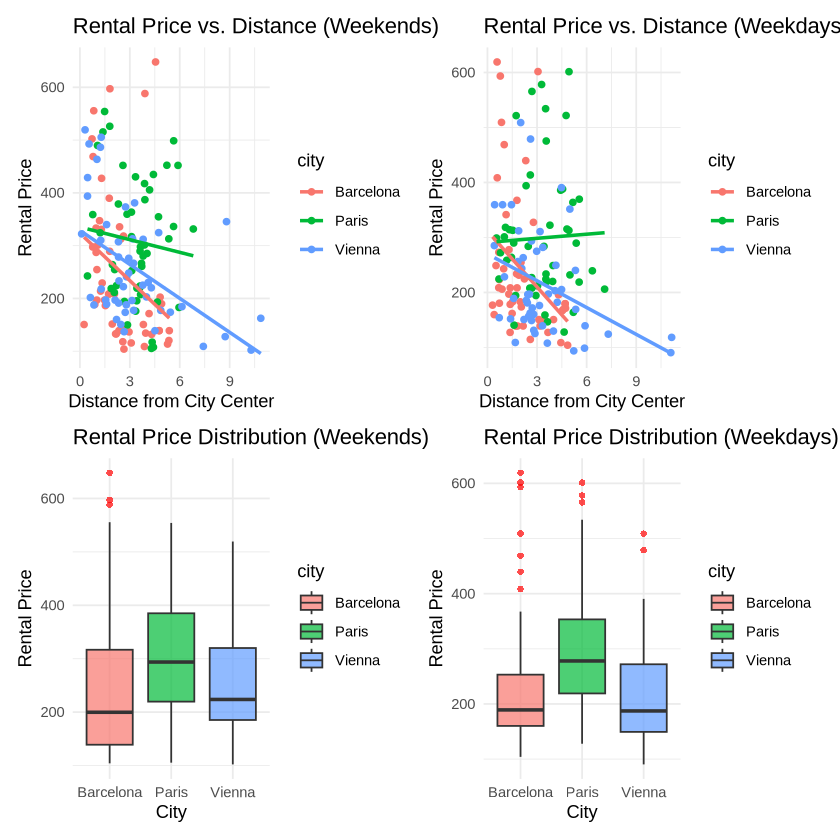

In [25]:
weekends_data <- subset(filtered_data, day_type == "weekend")

sampled_data <- weekends_data %>%
  group_by(city) %>%
  sample_n(50)

weekends_plot = ggplot(sampled_data, aes(x = dist, y = realSum, color = city)) +
  geom_point(alpha = 1) + 
  geom_smooth(method = "lm", se = FALSE) + 
  labs(title = "Rental Price vs. Distance (Weekends)",
       x = "Distance from City Center",
       y = "Rental Price") +
  theme_minimal()
boxplot_weekends <- ggplot(sampled_data, aes(x = city, y = realSum, fill = city)) +
  geom_boxplot(alpha = 0.7, outlier.colour = "red", outlier.shape = 16) +
  labs(title = "Rental Price Distribution (Weekends)",
       x = "City",
       y = "Rental Price") +
  theme_minimal()

weekdays_data <- subset(filtered_data, day_type == "weekday")

sampled_data <- weekdays_data %>%
  group_by(city) %>%
  sample_n(50)


weekdays_plot = ggplot(sampled_data, aes(x = dist, y = realSum, color = city)) +
  geom_point(alpha = 1) + 
  geom_smooth(method = "lm", se = FALSE) + 
  labs(title = "Rental Price vs. Distance (Weekdays)",
       x = "Distance from City Center",
       y = "Rental Price") +
  theme_minimal()

boxplot_weekdays <- ggplot(sampled_data, aes(x = city, y = realSum, fill = city)) +
  geom_boxplot(alpha = 0.7, outlier.colour = "red", outlier.shape = 16) +
  labs(title = "Rental Price Distribution (Weekdays)",
       x = "City",
       y = "Rental Price") +
  theme_minimal()

(weekends_plot | weekdays_plot) / (boxplot_weekends | boxplot_weekdays)

To investigate the factors that may influence Airbnb rental prices, we first explored the association between distance to city center, city, and the rental price, with a particular focus on differences between weekends and weekdays.

In the top two scatter plots, we examine the relationship between distance from the city center and rental price, separated by day type and colored by city. The fitted trend lines reveal that in Barcelona and Vienna, prices generally decrease as the distance increases, especially on weekdays, which suggests that central locations are priced at a premium. However, Paris shows a more complex trend where prices remain relatively stable or even increase slightly with distance on weekends, possibly due to high demand in outer districts.

The bottom two boxplots show the distribution of rental prices across cities. On both weekdays and weekends, Paris has the highest median prices and wider variability, while Vienna shows more moderate pricing. Barcelona has the lowest median price but exhibits several high-end outliers. These visualizations help identify both city-level pricing differences and outliers that may need further treatment in modeling (e.g., log transformation or removal).

Together, these plots highlight key features—location, time, and city identity—that are likely important predictors of rental price and suggest the presence of heteroskedasticity and non-linear effects, which will inform our model selection.

In [19]:
summary_table <- filtered_data %>%
  group_by(city, day_type) %>%
  summarise(
    n = n(),
    avg_price = round(mean(realSum, na.rm = TRUE), 2),
    median_price = round(median(realSum, na.rm = TRUE), 2),
    sd_price = round(sd(realSum, na.rm = TRUE), 2)
  )

print(summary_table)

`summarise()` has grouped output by 'city'. You can override using the
`.groups` argument.


# A tibble: 6 × 6
# Groups:   city [3]
  city      day_type     n avg_price median_price sd_price
  <fct>     <fct>    <int>     <dbl>        <dbl>    <dbl>
1 Barcelona weekday   1468      245.         202.    124. 
2 Barcelona weekend   1210      247.         197.    132. 
3 Paris     weekday   2788      324.         301.    125. 
4 Paris     weekend   3217      326.         300.    125. 
5 Vienna    weekday   1724      222.         204.     89.2
6 Vienna    weekend   1784      231.         210.     96.8


The summary table provides an overview of Airbnb listings across cities and day types. Paris has the highest average rental prices on both weekdays (€324) and weekends (€326), along with the largest number of listings. In contrast, Vienna exhibits the lowest prices and the smallest variability (SD ≈ €90–97), indicating a more stable pricing pattern. Interestingly, rental prices remain relatively stable between weekdays and weekends within each city, suggesting that location and city-specific factors may play a larger role in price variation than day type alone.

## Methods: Plan

Main Contributor: Juhi

Our variable selection process aims to select the best possible variables for our analysis using the lasso model. Our process follows the following steps:
- We start by splitting the data into testing and training sets (70% training, 30% testing)
- We then check for: normality of the residual, homoschedasticity and linearity.
- We then begin our lasso process by choosing the best value for lambda
- Once lambda is chosen, we predict the values of our training data based on our model.
- We finally calculate our RMSE, MAE and R^2. 

#### Variable Selection Process
Main Contributor: Qi Xu

We selected Lasso regression as the primary method for modeling Airbnb rental prices. Lasso extends traditional linear regression by incorporating an L1 regularization term, which encourages sparsity in the model coefficients. This has two major advantages: it performs automatic variable selection, and it reduces the impact of multicollinearity by shrinking correlated or unimportant predictors toward zero.

Given the number of explanatory variables in our dataset—including numerical ratings, binary indicators, and location-based features—Lasso is well-suited for balancing model complexity with interpretability. To avoid overfitting, we applied 10-fold cross-validation to choose the optimal penalty parameter (lambda). This approach ensures that the model generalizes well to unseen data and aligns with methods taught in class.

The Lasso model is appropriate for the characteristics of our dataset, which includes a mix of categorical and numerical predictors and a right-skewed continuous response variable (rental price). The presence of potentially irrelevant or correlated predictors makes Lasso a better choice than ordinary least squares, as it can regularize and exclude variables that do not contribute meaningfully to prediction.

Additionally, we validated the assumptions of linear modeling by checking the normality of residuals through a Q-Q plot and assessing homoscedasticity and linearity via a residual-vs-fitted plot. These diagnostic checks suggest that a linear model is reasonably appropriate.

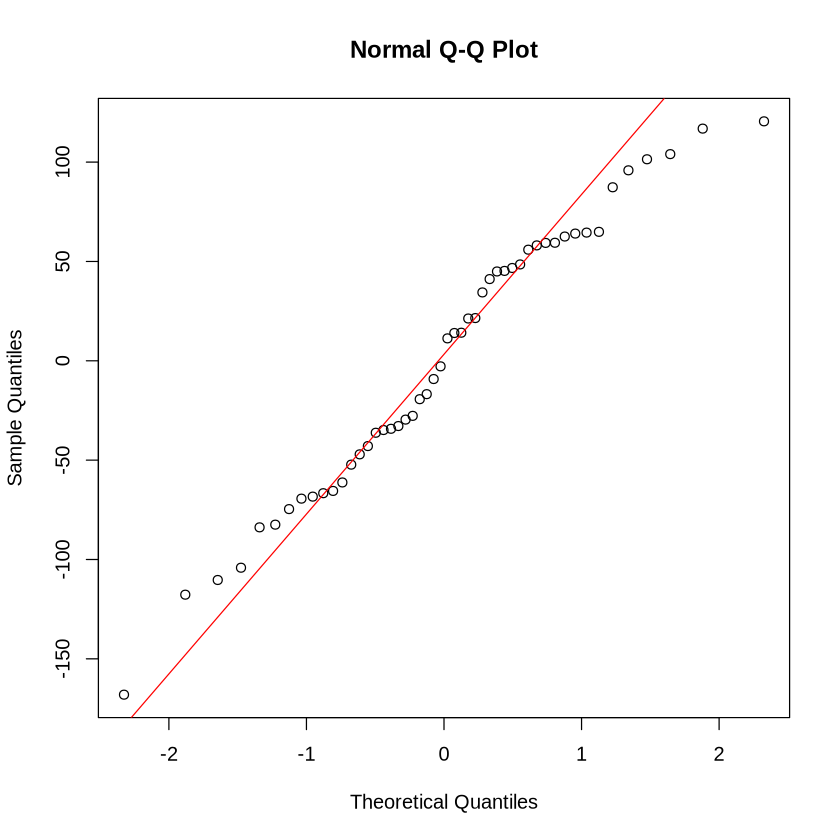

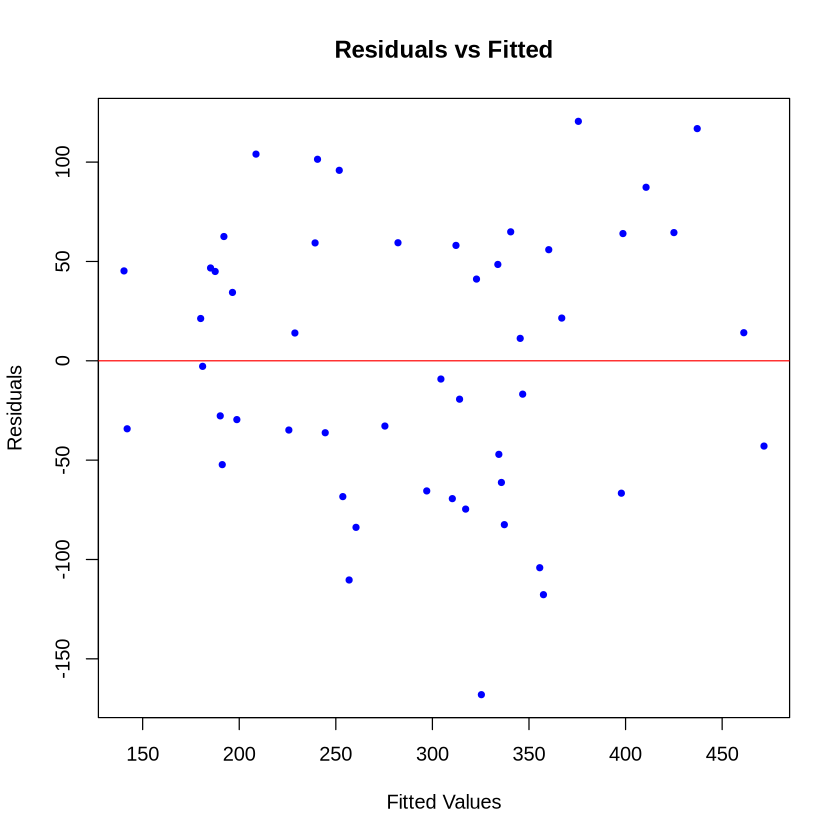

In [8]:
set.seed(123)

n <- nrow(filtered_data)
train_idx <- sample(1:n, size = 0.7 * n)

#Split data into Testing and Training Sets
train_data <- filtered_data[train_idx, ]
test_data  <- filtered_data[-train_idx, ]

#Check for Normality of residual
#Plot a Normal Q-Q Plot
sampled_data <- train_data %>%
  sample_n(50)
lm_model <- lm(realSum ~ ., data = sampled_data)
lm_residuals <- residuals(lm_model)
lm_fitted <- fitted(lm_model)
qqnorm(lm_residuals)
qqline(lm_residuals, col = "red")

#Check for Homoscedasticity and linearity
#Plot a Residual vs Fitted Plot
plot(lm_fitted, lm_residuals, 
     main = "Residuals vs Fitted", 
     xlab = "Fitted Values", 
     ylab = "Residuals",
     pch = 20, col = "blue")
abline(h = 0, col = "red")

To evaluate whether the assumptions of linear regression were reasonably met, we examined two diagnostic plots. The Q-Q plot of residuals shows mild deviation from the reference line at both tails, suggesting slight departures from normality, especially in the upper quantiles. However, the residuals are mostly aligned along the diagonal, indicating that the normality assumption is approximately satisfied. The Residuals vs Fitted plot does not exhibit strong funnel shapes or non-linear patterns, suggesting that the assumptions of homoscedasticity and linearity are largely reasonable. Together, these plots support the use of linear modeling techniques on our data.

[1] "Best lambda value: 0.154365768796049"
24 x 1 sparse Matrix of class "dgCMatrix"
                                      s0
(Intercept)                 2.294193e+01
...1                       -4.217864e-03
room_typePrivate room      -6.546723e+01
room_typeShared room       -1.929400e+02
room_sharedTRUE            -3.293625e-10
room_privateTRUE           -2.781759e+00
person_capacity             3.105769e+01
host_is_superhostTRUE       6.562614e+00
multi                       1.522785e+01
biz                         4.473768e+01
cleanliness_rating          1.027474e+01
guest_satisfaction_overall  8.627256e-02
bedrooms                    3.771900e+01
dist                       -2.291500e-01
metro_dist                  .           
attr_index                 -1.782426e-01
attr_index_norm             6.620271e+00
rest_index                  .           
rest_index_norm             1.140133e+00
lng                        -5.720745e+00
lat                         .           
cityParis    

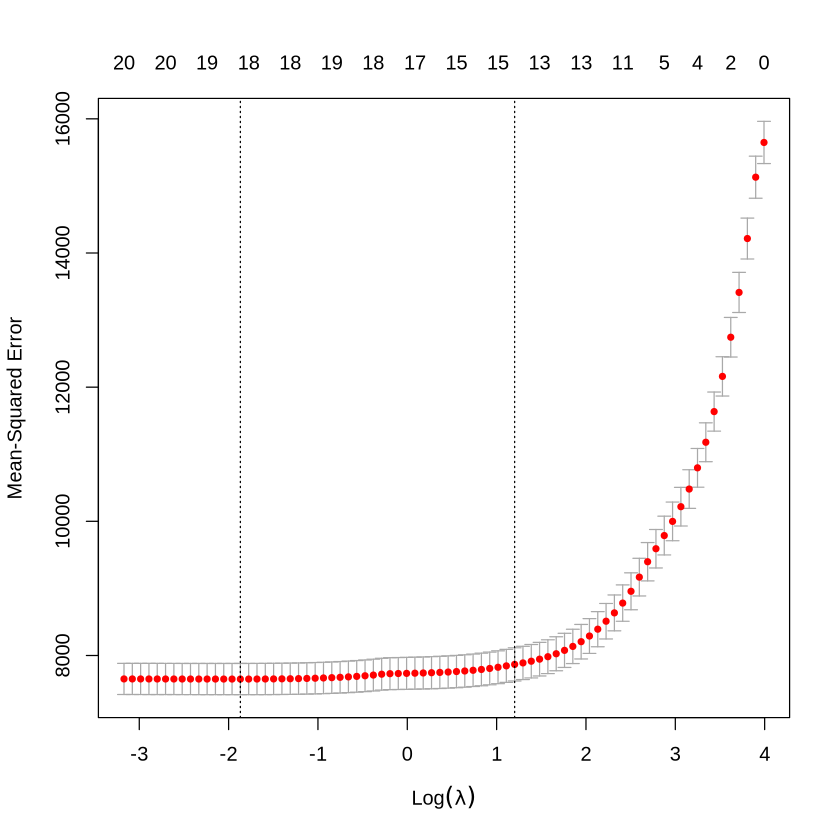

In [22]:
X <- model.matrix(realSum ~ ., data = train_data)[, -1]
y <- train_data$realSum

#Cv validate lasso
cv.lasso <- cv.glmnet(X, y, alpha = 1)

#Plot cv to see every lambda
plot(cv.lasso)

#Choose Best Lambda Value
best_lambda <- cv.lasso$lambda.min
print(paste("Best lambda value:", best_lambda))

#Fit Lasso Model
lasso_model <- glmnet(X, y, alpha = 1, lambda = best_lambda)
print(coef(lasso_model))

#Predict on Testing Data
X_test <- model.matrix(realSum ~ ., data = test_data)[, -1]
y_test <- test_data$realSum

y_pred <- predict(lasso_model, newx = X_test)

#Calculate accuracies (RMSE, MAE, R^2)
rmse <- sqrt(mean((y_test - y_pred)^2))
mae <- mean(abs(y_test - y_pred))
r2 <- 1 - sum((y_test - y_pred)^2) / sum((y_test - mean(y_test))^2)

cat("Test RMSE:", round(rmse, 2), "\n")
cat("Test MAE:", round(mae, 2), "\n")
cat("Test R-squared:", round(r2, 4), "\n")

To prevent overfitting and enhance interpretability, we applied Lasso regression with L1 regularization, which inherently performs variable selection by shrinking less relevant coefficients to zero. We used the cv.glmnet() function to perform 10-fold cross-validation, selecting the value of the penalty parameter λ that minimized the mean squared error on held-out folds. The selected lambda value was approximately 0.15, as shown in the cross-validation plot.

This regularization process reduced our model to a subset of informative predictors, including room_type, person_capacity, cleanliness_rating, guest_satisfaction_overall, bedrooms, dist, attr_index_norm, rest_index_norm, and day_type. Variables such as host_is_superhost, biz, and lng were also retained, while others (e.g., city dummies, room_shared, lat) were shrunk to zero and effectively excluded from the model.

The final Lasso model achieved a Test RMSE of 89.21, MAE of 67.53, and an R-squared of 0.5137, indicating that it explains approximately 51% of the variance in Airbnb rental prices on the test set. Among the retained variables, room_typePrivate and room_private had large negative coefficients, suggesting that private or fully private rooms tend to be priced significantly lower. In contrast, being a superhost and having higher cleanliness_rating or guest satisfaction scores were associated with higher prices, aligning with intuitive expectations.

Notably, day_typeWeekend had a positive coefficient (~8.67), indicating that listings are on average more expensive on weekends, controlling for other factors. The model also highlighted the influence of location-based features like dist (distance to city center) and rest_index_norm (restaurant accessibility), reinforcing the spatial component of rental pricing.

Overall, the model provides both predictive utility and interpretable insights into the key drivers of Airbnb pricing in European cities.

## Discussion

Main Contributor: Xuanye Zheng

Our project focused on predicting Airbnb rental prices using data from Paris, Barcelona, and Vienna. We addressed issues such as *missing values*, *negative prices*, and *outliers*. To reduce multicollinearity and select the most predictive variables, we used **Lasso regression**, which regularizes the model by penalizing less informative features. This process helped us to identify which features had the greatest influence on the final rental price (realSum). Among those retained by the Lasso model were `room_type`, `person_capacity`, `host_is_superhost`, `bedrooms`, `biz`, `cleanliness_rating`, and various attraction and location-related indices. Obviously, variables such as `metro_dist`, `rest_index`, and even `city` were not selected, which suggests either redundancy with other features or minimal marginal contribution to price prediction. Overall, the results were mostly in line with our expectations. Features like room_type, bedrooms, and person_capacity were strong predictors of price, which aligns with typical Airbnb pricing logic.

Our final model get a test `RMSE` of 89.2, `MAE` of 67.53, and an `R-squared` of 0.512. This means that around 51% of the variance in rental prices could be explained by the included predictors. While this is a moderate level of accuracy, it highlights the complexity of Airbnb pricing, which can be influenced by many external or unobserved factors not captured in the dataset. For instance, seasonality, reviews, or nearby events.

Looking ahead, the model could be improved by creating interaction terms or combining multiple distance-based variables into a unified measure of centrality. One area worth that is worth to explore is how seasonality and event-based demand affect Airbnb prices, especially in tourist-heavy cities.

## References

(at least two references expected in the introduction)

- reference 1
- reference 2